# Biofilm 1D solver class tutorial

**Maintainer: Brendan Harding**\
**Initial development: May 2020**\
**Last updated: August 2020**

This notebook acts as a brief tutorial on using the Biofilm 1D solver class contained in ```BiofilmOneDLubricationClass.py```.
The class implements solvers for the biofilm model described in:
 - *A Thin-Film Lubrication Model for Biofilm Expansion Under Strong Adhesion*,\
A. Tam, B. Harding, J.E.F. Green, S. Balasuriya, and B.J. Binder,\
To be submitted soon, 2020. 

which builds upon the model developed by Alex Tam in his PhD thesis:
 - *Mathematical Modelling of Pattern Formation in Yeast Biofilms*,\
Alex Tam,\
The University of Adelaide, 2019.

First, the following cell will load a few standard Python libraries, set a couple of plotting parameters, and import the solver class. Note: if you don't have latex on your system you should change the ```usetex=True``` option to ```usetex=False``` (or just comment out this line with a # at the front).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('text',usetex=True)
plt.rc('font',size=14)
from BiofilmOneDLubricationClass import BiofilmOneDLubricationModel
from BiofilmOneDPlottingHelper import Plot1DFields

## Accessing documentation

The class itself contains some quite a bit of documentation (although is far from complete). 
You can print the entire documentation using ```help(BiofilmOneDLubricationModel)```. 
You'll see a some documentation for the entire class, then a list of available methods and their arguments along with a brief description for each.

The documentation for a specific class method can also be printed on its own using ```help(BiofilmOneDLubricationModel.solve)``` for example.

(The class also contains a large number of *private* methods, but are not shown in the help as it is not expected that the typical user should call them directly. More advanced users can look directly at the class code to learn about these.)

In [2]:
help(BiofilmOneDLubricationModel)

Help on class BiofilmOneDLubricationModel in module BiofilmOneDLubricationClass:

class BiofilmOneDLubricationModel(builtins.object)
 |  BiofilmOneDLubricationModel(R=2.0, dr=0.0078125, dt=None, params=None, solver='DCN', verbose=False)
 |  
 |  Helper class for solving the PDE describing the development of 
 |  a radially symmetric and thin yeast biofilm over time.
 |  The model/system that is solved includes the biofilm height,
 |  the cell concentration, and the nutrient concentrations in both
 |  the biofilm and the substrate.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, R=2.0, dr=0.0078125, dt=None, params=None, solver='DCN', verbose=False)
 |      Initialise the class
 |      
 |      With no arguments a default problem set up is initialised.
 |      
 |      Optionally you may pass the following:
 |      R: The radius of the domain (or petri dish). If not specified
 |      a default value of 2 is used.
 |      dr: The grid spacing used for the discretisation of the dom

## Getting started

Okay, now let's get started shall we.
The following cell initialises an instance of the class using a default setup (no arguments).
We then fetch and plot the initial conditions so you can see how to do this from the interface.

Initial conditions can be changed using the corresponding ```set_...``` method, e.g. ```set_g_s```.
For each of these you can either pass a function which the clas will then sample on an appropriate grid/array, or you can pass an array directly (although it must be the same length as the ```r``` variable within the class).

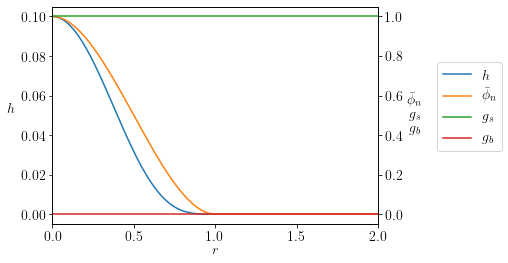

In [3]:
# Initialise the class using all internal defaults
BLM_1D = BiofilmOneDLubricationModel()

# Fetch the initial conditions
r = BLM_1D.get_r()
h = BLM_1D.get_h()
phi_n = BLM_1D.get_phi_n()
g_s = BLM_1D.get_g_s()
g_b = BLM_1D.get_g_b()

# Plot the initial conditions, include a legend
Plot1DFields(r,h,phi_n,g_s,g_b)
plt.show()

## Getting and setting parameters

You can get and set the parameters for the class using the ```get_parameters``` and ```set_parameters``` methods.
If ```get_parameters()``` is called with no arguments it returns all the parameters as a dictionary. Alternatively specific parameters can be fetched by passing their name as a string, e.g. ```get_parameters('Pe')```.

To use ```set_parameters``` you must pass a dictionary of the parameters you wish to set. E.g. to set $\mathrm{Pe}=10$ and $\Upsilon=5$ you would call ```set_parameters({'Pe':10,'Upsilon':5})```. You need only include those parameters you wish to change. Alternatively, the dictionary returned by ```get_parameters()``` can also be edited directly (it is a reference rather than a copy), although I advise against this approach.

Note: there are a couple of parameters which cannot be changed, ```R``` and ```dr``` in particular. 
If, for some reason, you wanted to change these, the best thing to do is create a new instance of a class where the desired ```R``` and ```dr``` must be specified during initialisation. You then need to manually reset other parameters and initial conditions as needed.

Here we will change the slip parameter $\lambda^{\ast}$ to a finite number, say $100$ (noting $\lambda^{\ast}=\infty$ by default).

In [4]:
print(BLM_1D.get_parameters())
BLM_1D.set_parameters({'lambda_ast':100.0})
print(BLM_1D.get_parameters())

{'b': 0.0001, 'H0': 0.1, 'Psi_m': 0.111, 'Psi_d': 0.0, 'gamma_ast': 1.0, 'D': 1.05, 'Pe': 3.94, 'Upsilon': 3.15, 'Q_b': 8.65, 'Q_s': 2.09, 'h_ast': 0.002, 'lambda_ast': inf}
{'b': 0.0001, 'H0': 0.1, 'Psi_m': 0.111, 'Psi_d': 0.0, 'gamma_ast': 1.0, 'D': 1.05, 'Pe': 3.94, 'Upsilon': 3.15, 'Q_b': 8.65, 'Q_s': 2.09, 'h_ast': 0.002, 'lambda_ast': 100.0}


## Solving

Okay, now let's run the (default) solver for a duration of $T=2$ units and plot the result.

Note that the call to solve returns the solutions at the end (in the order $h,\Phi_n,g_s,g_b$). Observe that $\Phi_n$ is returned as opposed to $\bar{\phi}_n=\phi_n$ as $\Phi_n$ is what the solver computed internally. It is straightforward to convert calculate $\bar{\phi}_n=\Phi_n/h$ though.

Calling to solve again will continue to evolve the solution for the specified period of time from the current solution.

Beware: Currently if you evolve so long that the biofilm reaches the right hand wall then the solver will fail. (This will be fixed at some point in the future.)

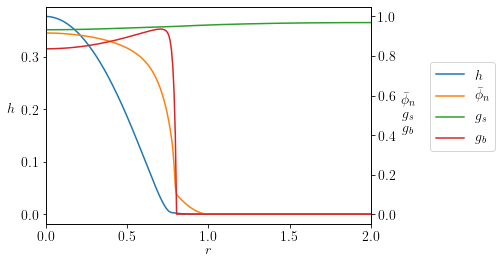

In [5]:
# Solve for 2 units in time
solution = BLM_1D.solve(2.0)
h = solution[0]
phi_n = solution[1]/solution[0] # Phi_n/h
g_s = solution[2]
g_b = solution[3]

# Plot the solutions
Plot1DFields(r,h,phi_n,g_s,g_b)
plt.show()

## More complex use case

Okay, now let's re-initialise the class on a larger domain, solve over several time periods, plotting the solutions as we go.

Note: this may take several minutes to complete.

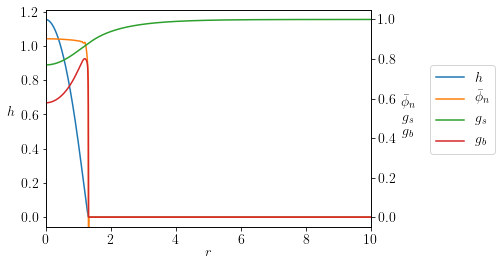

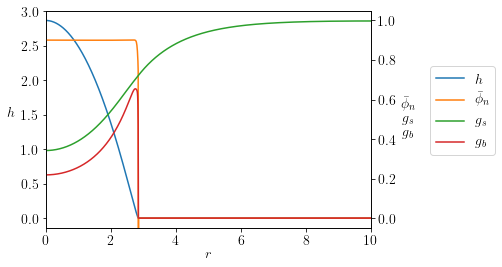

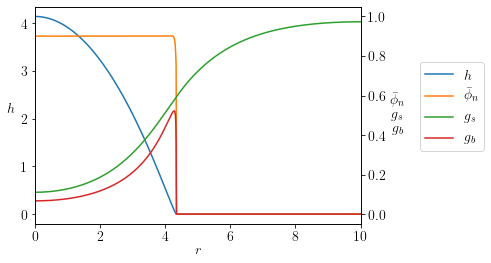

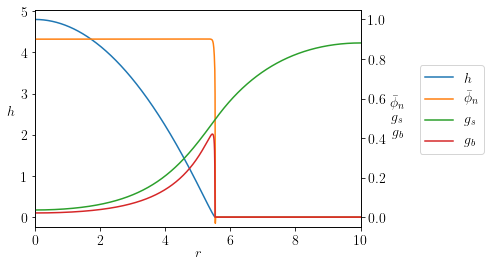

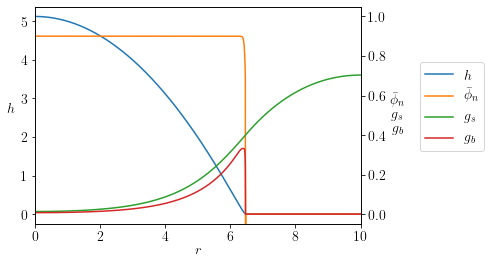

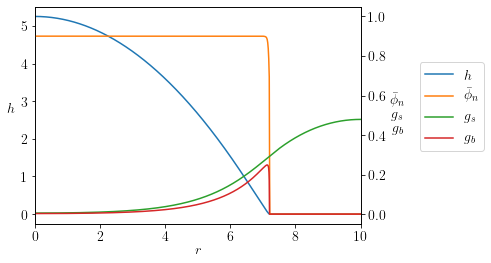

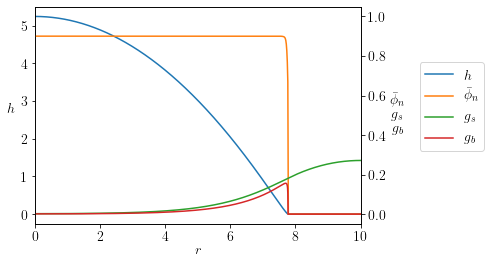

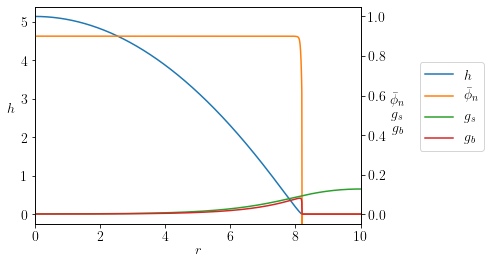

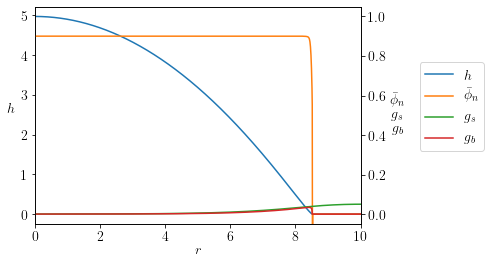

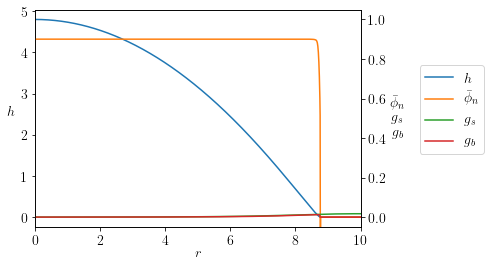

In [6]:
# Initialise the class 
BLM_1D = BiofilmOneDLubricationModel(R=10.0,params={'lambda_ast':100.0})

r = BLM_1D.get_r()
h = BLM_1D.get_h()
Phi_n = BLM_1D.get_Phi_n()
phi_n = BLM_1D.get_phi_n()
g_s = BLM_1D.get_g_s()
g_b = BLM_1D.get_g_b()
initial = [h.copy(),Phi_n.copy(),g_s.copy(),g_b.copy()]
results = []

if True:
    for _ in range(10):
        solution = BLM_1D.solve(5.0)
        results.append([sol.copy() for sol in solution]) # ensure copies are recorded
        h = solution[0]
        phi_n = solution[1]/solution[0] # Phi_n/h
        g_s = solution[2]
        g_b = solution[3]
        Plot1DFields(r,h,phi_n,g_s,g_b)
        plt.show()

## Alternative plot of results

The following cell takes all of the results computed, stored in the list ```results```, and plots them analogous to figure 6.4 in Alex Tam's thesis (albeit we have added some slip here).

Note: these can be saved by calling ```plt.savefig(...)``` with suitable arguments immediately before ```plt.show()```.

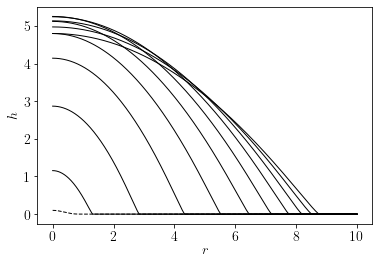

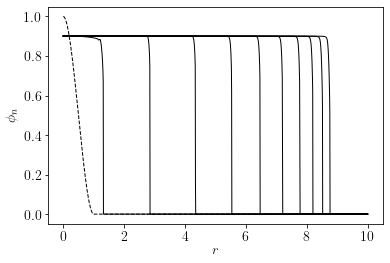

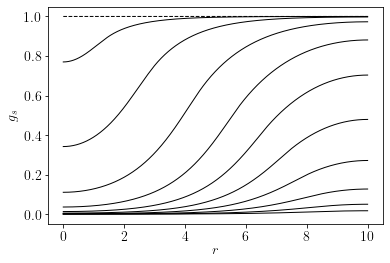

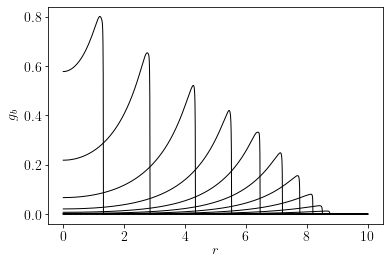

In [7]:
# Plot all of the h solutions together...    
plt.plot(r,initial[0],'k--',lw=1)
for i in range(10):
    plt.plot(r,results[i][0],'k-',lw=1)
plt.xlabel(r'$r$',labelpad=0)
plt.ylabel(r'$h$')
plt.show()

# Plot all of the phi_n solutions together...   
plt.plot(r,initial[1]/initial[0],'k--',lw=1) 
for i in range(10):
    phi_n_i = np.maximum(results[i][1]/results[i][0],0*r)
    plt.plot(r,phi_n_i,'k-',lw=1)
plt.xlabel(r'$r$',labelpad=0)
plt.ylabel(r'$\phi_n$')
plt.show()

# Plot all of the g_s solutions together...  
plt.plot(r,initial[2],'k--',lw=1)   
for i in range(10):
    plt.plot(r,results[i][2],'k-',lw=1)
plt.xlabel(r'$r$',labelpad=0)
plt.ylabel(r'$g_s$')
plt.show()

# Plot all of the g_b solutions together...    
plt.plot(r,initial[3],'k--',lw=1) 
for i in range(10):
    plt.plot(r,results[i][3],'k-',lw=1)
plt.xlabel(r'$r$',labelpad=0)
plt.ylabel(r'$g_b$')
plt.show()

## It's in you hands now, go nuts!

Feel free to contact me if you ever have any queries/questions.